In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from openap import top, aero
from matplotlib.colors import TwoSlopeNorm

import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from cartopy.feature import OCEAN, LAND, BORDERS

from openap.top import tools
from openap.top import vis


## Define objective function

Here I am using a three hump camel function to simulate a complex cost gird. You can also test with the six hump_camel function for more local minima.

In [2]:
def three_hump_camel(x, y):
    return 2 * x**2 - 1.05 * x**4 + x**6 / 6 + x * y + y**2


def six_hump_camel(x, y):
    return (4 - 2.1 * x**2 + x**4 / 3) * x**2 + x * (y) + (-4 + 4 * (y)**2) * (y)**2


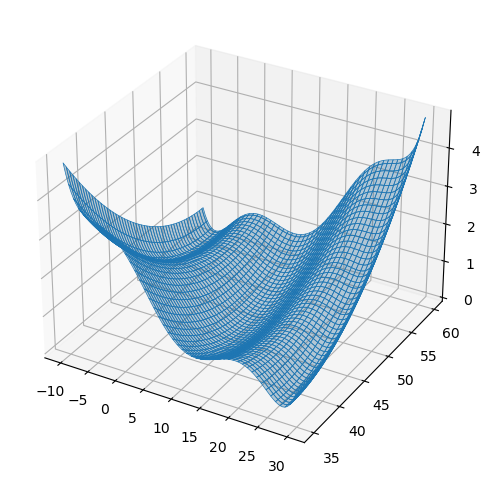

In [3]:
# search ranges for the hump functions
x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 1, 100)

z = np.linspace(0, 13_000, 100)
X, Y, Z = np.meshgrid(x, y, z)

V = three_hump_camel(X, Y)
V = V-V.min()

# re-scale to our lon/lat grid
x_ = np.interp(x, (min(x), max(x)), (-10, 30))
y_ = np.interp(y, (min(y), max(y)), (35, 60))
X, Y, Z = np.meshgrid(x_, y_, z)

ax = plt.figure(figsize=(8,6)).add_subplot(projection="3d")
ax.plot_surface(
    X[:, :, 0], Y[:, :, 0], V[:, :, 0], edgecolor="tab:blue", lw=0.5, alpha=0.3
)
plt.show()

## construct the cost data frame

Your own cost should have the same structure as follows

In [4]:
df_cost = pd.DataFrame(
    np.array([X, Y, Z, V]).reshape(4, -1).T,
    columns=["longitude", "latitude", "h", "cost"],
).sort_values(["h", "latitude", "longitude"])

df_cost

,longitude,latitude,h,cost
0,-10.000000,35.0,0.0,4.865953
100,-9.595960,35.0,0.0,4.593207
200,-9.191919,35.0,0.0,4.368412
300,-8.787879,35.0,0.0,4.185164
400,-8.383838,35.0,0.0,4.037583
...,...,...,...,...
999599,28.383838,60.0,13000.0,4.037583
999699,28.787879,60.0,13000.0,4.185164
999799,29.191919,60.0,13000.0,4.368412
999899,29.595960,60.0,13000.0,4.593207


## Set up the new objective function

General steps to set you own objective function / cost grid:

1. generate the interpolate model (linear) based on the grid data
2. define the objective function
3. pass the new objective function and interplant model to optimizer's `trajectory()` generator

(Note: this process can take a while, ~1 minute with a modern computer)

In [5]:
optimizer = top.Cruise("A320", "EHAM", "LGAV", m0=0.85)
optimizer.init_conditions(h_min=32_000 * aero.ft, h_max=36_000 * aero.ft)
optimizer.fix_cruise_altitude()
optimizer.setup_dc(nodes=40)
optimizer.debug = False

# the inpterpolant required for the cost grid
interpolant = tools.interp_grid(
    df_cost.longitude.unique(),
    df_cost.latitude.unique(),
    df_cost.h.unique(),
    df_cost.cost,
    shape="linear",
)


# here I assume the cost is related to the fuel consumption, hence the product
def obj_grid(x, u, dt, **kwargs):
    cost = optimizer.obj_grid_cost(x, u, dt, **kwargs)
    fuel = optimizer.obj_fuel(x, u, dt, **kwargs)
    return cost * fuel
    # return value


# generate the flight trajectory
# interpolant is passed to trajectory() and then to obj_grid() internally
flight = optimizer.trajectory(
    objective=obj_grid,
    interpolant=interpolant,
    h_min=32_000 * aero.ft,
    h_max=36_000 * aero.ft,
)


## Visualize the trajectory

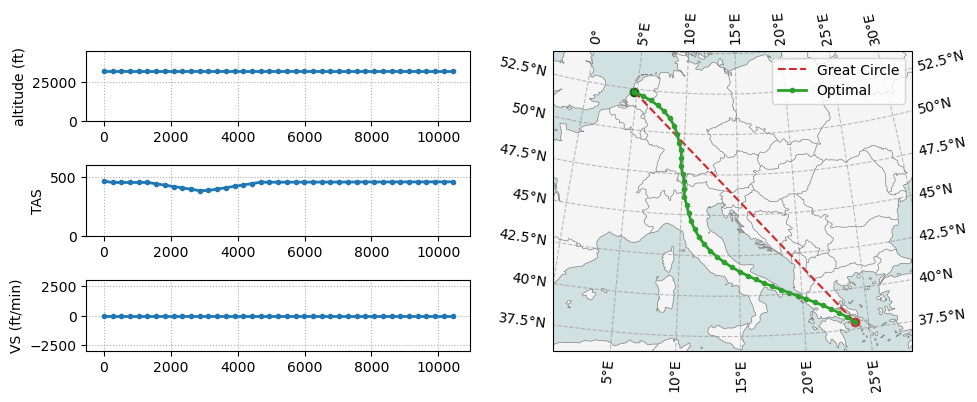

In [6]:
vis.trajectory(flight)
plt.show()

### Visualize with the cost grid

Note that the trajectory follows the lower cost grid points

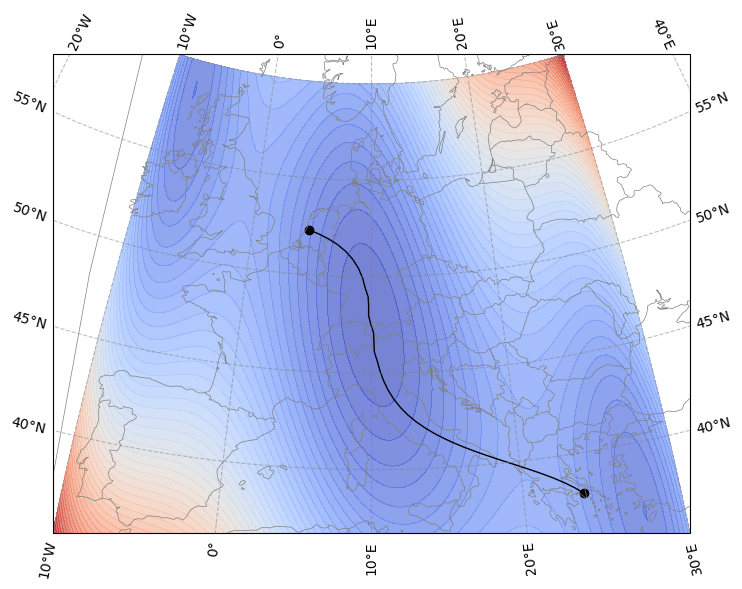

In [7]:
idx = np.abs(df_cost.h.unique() - flight.h.mean()).argmin()

fig, ax = plt.subplots(
    1,
    1,
    figsize=(8, 6),
    subplot_kw=dict(
        projection=ccrs.TransverseMercator(central_longitude=10, central_latitude=50)
    ),
)

ax.set_extent([-10, 30, 35, 60])
ax.add_feature(BORDERS, lw=0.5, color="gray")
ax.gridlines(draw_labels=True, color="gray", alpha=0.5, ls="--")
ax.coastlines(resolution="50m", lw=0.5, color="gray")

df_cost_pivot = df_cost.query("h==0").pivot(
    index="latitude", columns="longitude", values="cost"
)

lat, lon, val = df_cost_pivot.index.values, df_cost_pivot.columns.values, df_cost_pivot.values

ax.contourf(
    lon,
    lat,
    val,
    transform=ccrs.PlateCarree(),
    alpha=0.7,
    cmap="coolwarm",
    levels=50,
)

ax.plot(flight.lon, flight.lat, color="k", lw=1, transform=ccrs.PlateCarree())

ax.scatter(flight.lon.iloc[0], flight.lat.iloc[0], c="k", transform=ccrs.PlateCarree())
ax.scatter(flight.lon.iloc[-1], flight.lat.iloc[-1], c="k", transform=ccrs.PlateCarree())

plt.tight_layout()
